$V(x)=\sum_{t=1}^T R(x(t))$ \
where  $R(x)=-\|x-x_{goal}\|-variance$ \
and $T=30$

Use all datas 

# Create Environment

In [16]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from tqdm import tqdm

global N

N=100

global M
M=10

global T
global target
T=30
target=np.array([3,2])
global w
w=np.pi*2/23.7

global delta_t
delta_t=T/N

global obs_para
obs_para=6

global beta
beta=[0.95,0.975,1,1.025,1.05]

global num_system
num_system=5


global coeff
coeff=[1 for i in range(N+1)]

In [17]:
def Z(vecs, u, v):
    output=[]
    for i in range(num_system):
        vec=vecs[i]
        x=vec[0]
        y=vec[1]
        theta=vec[2]
        output.append([beta[i]*np.cos(theta)*u,beta[i]*np.sin(theta)*u,beta[i]*v])
    return np.array(output)

#check the correctness of Z
'''
x = np.linspace(0, 6.5, 1001)
plt.plot(x, Z(x))
plt.xlabel('Angle [rad]')
plt.ylabel('Z(theta)')
plt.grid()
plt.show()
'''

"\nx = np.linspace(0, 6.5, 1001)\nplt.plot(x, Z(x))\nplt.xlabel('Angle [rad]')\nplt.ylabel('Z(theta)')\nplt.grid()\nplt.show()\n"

In [18]:
def next_step(vecs,action):  
    u=action[0]
    v=action[1]
   
    for j in range(M):
        vecs_new=[]
        diff=Z(vecs,u,v)
        for i in range(num_system):
            w=vecs[i]+delta_t/M*diff[i]
            '''
            if w[2]>np.pi:
                w[2]-=2*np.pi
            if w[2]<-np.pi:
                w[2]+=2*np.pi
            '''
            vecs_new.append(w)
        vecs=np.array(vecs_new)
    return vecs

def observe(vecs):
    mu_x=0
    mu_y=0
    mu_theta=0
    var_x=0
    var_y=0
    var_theta=0
    for i in range(num_system):
        mu_x+=vecs[i][0]
        mu_y+=vecs[i][1]
        mu_theta+=vecs[i][2]
        var_x+=vecs[i][0]**2
        var_y+=vecs[i][1]**2
        var_theta+=vecs[i][2]**2
    var_x-=mu_x**2/num_system
    var_y-=mu_y**2/num_system
    var_theta-=mu_theta**2/num_system
    
    w=np.array([mu_x,mu_y,mu_theta,var_x,var_y,var_theta])/num_system
    if w[2]>np.pi:
        w[2]-=2*np.pi
    if w[2]<-np.pi:
        w[2]+=2*np.pi
    return w

def reward(obs):
    return max(100-(obs[0]-target[0])**2-(obs[1]-target[1])**2-obs[3]-obs[4],0)

def reward_raw(position):
    r=0
    for i in range(num_system):
        r+=np.linalg.norm(position[i,[0,1]]-target)
    return r

def value_func(funcs,flags,next_state):
    result=[]
    for i in range(6):
        if flags[i]:
            result.append(0)
        else:
            k,_=funcs[i].predict(next_state.reshape(-1,obs_para), return_std=True)
            result.append(k[0])
    result=np.array(result)
    return np.max(result)

# Learning Settings

In [19]:
global lr
lr=0.01
global eps
eps=0.2
global max_u
max_u=2
global precision
precision=0.0002
global action_set
action_set=np.array([[1,np.pi/4],[-1,np.pi/4],[1,0],[-1,0],[1,-np.pi/4],[-1,-np.pi/4]])

def exploration():
    a=np.random.uniform()
    if a<eps:
        return True
    else:
        return False

def find_max(cand):
    return np.argmax(cand)
    
def decide_u(funcs,flags,state,init=False):
    explo=exploration()
    if init or explo:
        return np.random.randint(6)
    else:
        result=[]
        for i in range(6):
            if flags[i]:
                return i
            else:
                k,_=funcs[i].predict(state.reshape(-1,obs_para), return_std=True)
                result.append(k[0])
    result=np.array(result)
    return np.argmax(result)
    
def decide_u_exploitation(funcs,flags,state,init=False):
    result=[]
    for i in range(6):
        if flags[i]:
            print("Err",i)
            return i
        else:
            k,_=funcs[i].predict(state.reshape(-1,obs_para), return_std=True)
            result.append(k[0])
    result=np.array(result)
    return np.argmax(result)

history_su=[0 for i in range(6)]
history_r=[0 for i in range(6)]
history_su_next=[0 for i in range(6)]
flags=[True for i in range(6)]

history_rt=[[[] for i in range(6)] for j in range(N+1)]
history_sut=[[[] for i in range(6)] for j in range(N+1)]
flags_t=[[True for i in range(6)] for j in range(N+1)]

# Simulation


In [20]:
num_iter=80

position_result=[]
observation_result=[]
gpr_list=[[0 for i in range(6)] for j in range(N+1)]

best_r=-10000
best_obs=[]
best_pos=[[] for i in range(num_system)]
best_u=[]

for iterr in tqdm(range(num_iter)):
    #initialize
    position=np.array([[-2,-2,0] for _ in range(num_system)])
    observation=observe(position)
    u_t=[]
    r_t=[]
    observation_t=[observation]
    position_t=[[] for i in range(num_system)]
    
    
    history_target=[0 for i in range(6)]
    
    
    for time in range(N+1):
        if iterr<5:
            #candidates_u=[]
            u_k = decide_u(gpr_list[time],flags,observation,init=True)
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            r_t.append(r)
            
            if flags[u_k]:
                history_su[u_k] = observation.reshape(-1,obs_para)
                history_su_next[u_k] = observation_new.reshape(-1,obs_para)  
                history_r[u_k] = np.array([r])
                flags[u_k]=False
            else:
                history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,obs_para)))
                history_su_next[u_k] = np.concatenate((history_su_next[u_k], observation_new.reshape(-1,obs_para)))
                history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
        else:
            #candidates_u=[]
            u_k = decide_u(gpr_list[time],flags,observation)
            #print(candidates_u)
            #u_k, explo = decide_u(observation,np.array(candidates_u))
            
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            r_t.append(r)
            
            history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,obs_para)))
            history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            history_su_next[u_k] = np.concatenate((history_su_next[u_k], observation_new.reshape(-1,obs_para)))
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
            
            
    #update
    #calculate cumulative r 
    

    '''
    for j in range(6):
        history_target[j]=last_coeff*history_r[u_t[-i]]
        gpr_list[-i][j]=GaussianProcessRegressor(alpha=1e-4).fit(history_su[j], history_target[j])
    '''  
         
    #TODO
       
    for i in range(N+1):
        if i==1:
            for j in range(6):
                history_target[j]=coeff[-1]*history_r[j]
                gpr_list[-i][j]=GaussianProcessRegressor(alpha=1e-4).fit(np.array(history_su[j]).reshape(-1,obs_para), history_target[j].reshape(-1,1))
            
        elif i>1:
            for j in range(6):
                history_tar=[]
                for k in range(history_r[j].shape[0]):
                    history_tar.append(coeff[N+1-i]*history_r[j][k]+value_func(gpr_list[-i+1],flags_t[-i+1],history_su_next[j][k]))
                gpr_list[-i][j]=GaussianProcessRegressor(alpha=1e-4).fit(np.array(history_su[j]).reshape(-1,obs_para), np.array(history_tar).reshape(-1,1))
            '''
            r_t[-i]=0.5**(N+1-i)*r_t[-i]+value_func(gpr_list[-i+1],flags_t[-i+1],observation_t[-i+1])
            history_rt[-i][u_t[-i]].append(r_t[-i])
            history_sut[-i][u_t[-i]].append(observation_t[-i])
            gpr_list[-i][u_t[-i]]=GaussianProcessRegressor(alpha=1e-4).fit(np.array(history_sut[-i][u_t[-i]]).reshape(-1,5), np.array(history_rt[-i][u_t[-i]]).reshape(-1,1))
            if flags_t[-i][u_t[-i]]:
                flags_t[-i][u_t[-i]]=False
            '''
    for j in range(6):
        history_tar=[]
        for k in range(history_r[j].shape[0]):
            history_tar.append(coeff[0]*history_r[j][k]+value_func(gpr_list[1],flags_t[1],history_su_next[j][k]))
        gpr_list[0][j]=GaussianProcessRegressor(alpha=1e-4).fit(np.array(history_su[j]).reshape(-1,obs_para), np.array(history_tar).reshape(-1,1))

            
        
    print("observation =",observation)
    #print(observation_t)
    position_result.append(position)
    observation_result.append(observation)
    if r>best_r:
        best_r=r
        best_obs=observation_t
        best_pos=position_t
        best_u=u_t
    
    #print(history_su.shape)
    #print(u_t)

  1%|█                                                                                  | 1/80 [00:01<01:20,  1.01s/it]

observation = [-0.93923149 -1.89329073  1.64933614  0.00466296  0.00231223  0.00340039]


  2%|██                                                                                 | 2/80 [00:02<01:26,  1.11s/it]

observation = [-2.29431739e+00  2.95976270e+00  9.42477796e-01  6.98383414e-02
  3.04756700e-02  1.11033050e-03]


  4%|███                                                                                | 3/80 [00:03<01:30,  1.18s/it]

observation = [-1.89219790e+00 -2.73194749e+00 -1.88495559e+00  1.40748747e-03
  2.06127287e-02  4.44132198e-03]


  5%|████▏                                                                              | 4/80 [00:04<01:30,  1.20s/it]

observation = [-4.98409401e+00 -3.06876455e+00 -1.17809725e+00  2.29145172e-02
  2.70717940e-04  1.73489140e-03]


  6%|█████▏                                                                             | 5/80 [00:06<01:43,  1.39s/it]

observation = [-2.51700965e+00  2.65262106e-01  2.82743339e+00  2.57227194e-02
  1.86297815e-03  9.99297446e-03]


  8%|██████▏                                                                            | 6/80 [00:08<01:56,  1.58s/it]

observation = [ 2.46667177e-01 -5.96568785e-01  7.06858347e-01  2.37135152e-03
  8.50723321e-03  6.24560904e-04]


  9%|███████▎                                                                           | 7/80 [00:10<02:05,  1.72s/it]

observation = [3.99803827e-01 7.41767055e-02 1.41371669e+00 6.65253448e-04
 1.65128895e-02 2.49824361e-03]


 10%|████████▎                                                                          | 8/80 [00:12<02:18,  1.92s/it]

observation = [4.74242318e-01 5.74966059e-01 1.17809725e+00 2.42186775e-05
 2.20641259e-02 1.73489140e-03]


 11%|█████████▎                                                                         | 9/80 [00:14<02:24,  2.04s/it]

observation = [9.68970251e-01 3.11247815e-01 7.06858347e-01 1.86203433e-03
 2.13299711e-02 6.24560904e-04]


 12%|██████████▎                                                                       | 10/80 [00:17<02:37,  2.25s/it]

observation = [0.92179681 0.71975089 0.9424778  0.00141383 0.03091787 0.00111033]


 14%|███████████▎                                                                      | 11/80 [00:20<02:49,  2.46s/it]

observation = [9.06003318e-01 1.45247769e+00 4.71238898e-01 1.33643580e-03
 4.97491744e-02 2.77582624e-04]


 15%|████████████▎                                                                     | 12/80 [00:24<03:08,  2.77s/it]

observation = [1.88143762e+00 1.03853670e+00 7.06858347e-01 3.20104343e-03
 3.67145421e-02 6.24560904e-04]


 16%|█████████████▎                                                                    | 13/80 [00:29<03:52,  3.47s/it]

observation = [1.34885026e+00 1.84171498e+00 2.35619449e-01 1.56703284e-03
 6.35277349e-02 6.93956559e-05]


 18%|██████████████▎                                                                   | 14/80 [00:33<04:03,  3.69s/it]

observation = [1.77591532e+00 1.86475655e+00 2.35619449e-01 6.78542447e-03
 6.83682359e-02 6.93956559e-05]


 19%|███████████████▍                                                                  | 15/80 [00:37<04:14,  3.91s/it]

observation = [1.73437662e+00 1.83464329e+00 7.06858347e-01 9.15992402e-05
 4.98459945e-02 6.24560904e-04]


 20%|████████████████▍                                                                 | 16/80 [00:43<04:38,  4.36s/it]

observation = [2.00927585e+00 2.32153790e+00 4.71238898e-01 4.48589305e-03
 8.24043278e-02 2.77582624e-04]


 21%|█████████████████▍                                                                | 17/80 [00:48<04:57,  4.72s/it]

observation = [1.51305354e+00 2.13090030e+00 9.42477796e-01 3.45138631e-03
 7.02910158e-02 1.11033050e-03]


 22%|██████████████████▍                                                               | 18/80 [00:55<05:28,  5.30s/it]

observation = [ 2.21710796e+00  2.35092059e+00 -4.71238898e-01  8.02750985e-03
  7.58584516e-02  2.77582624e-04]


 24%|███████████████████▍                                                              | 19/80 [01:01<05:45,  5.67s/it]

observation = [ 1.72623319e+00  1.80031918e+00 -7.06858347e-01  1.42983261e-02
  6.57641956e-02  6.24560904e-04]


 25%|████████████████████▌                                                             | 20/80 [01:09<06:05,  6.10s/it]

observation = [ 2.39170044e+00  1.50259775e+00 -7.06858347e-01  4.54225372e-03
  4.97334105e-02  6.24560904e-04]


 26%|█████████████████████▌                                                            | 21/80 [01:16<06:29,  6.60s/it]

observation = [ 2.33870988e+00  1.83818690e+00 -4.71238898e-01  3.92016321e-03
  5.94502734e-02  2.77582624e-04]


 28%|██████████████████████▌                                                           | 22/80 [01:25<06:56,  7.17s/it]

observation = [2.27437006e+00 1.76628004e+00 4.71238898e-01 3.09445038e-03
 5.83353673e-02 2.77582624e-04]


 29%|███████████████████████▌                                                          | 23/80 [01:38<08:27,  8.90s/it]

observation = [3.00288357e+00 1.39130380e+00 2.35619449e-01 8.08299440e-03
 4.69085742e-02 6.93956559e-05]


 30%|████████████████████████▌                                                         | 24/80 [01:48<08:48,  9.44s/it]

observation = [2.40757965e+00 1.68809764e+00 9.42477796e-01 4.32942558e-03
 5.90368801e-02 1.11033050e-03]


 31%|█████████████████████████▋                                                        | 25/80 [02:00<09:15, 10.10s/it]

observation = [2.98885806e+00 1.75624298e+00 2.35619449e-01 7.80935400e-03
 5.91748442e-02 6.93956559e-05]


 32%|██████████████████████████▋                                                       | 26/80 [02:12<09:41, 10.76s/it]

observation = [3.27404527e+00 1.75513782e+00 2.35619449e-01 2.44166776e-02
 6.15911920e-02 6.93956559e-05]


 34%|███████████████████████████▋                                                      | 27/80 [02:25<10:05, 11.43s/it]

observation = [2.71976183e+00 2.20929369e+00 4.71238898e-01 3.77701662e-03
 7.25456452e-02 2.77582624e-04]


 35%|████████████████████████████▋                                                     | 28/80 [02:40<10:46, 12.43s/it]

observation = [3.08599641e+00 1.64508875e+00 9.42477796e-01 9.44593196e-03
 5.73122726e-02 1.11033050e-03]


 36%|█████████████████████████████▋                                                    | 29/80 [02:56<11:28, 13.51s/it]

observation = [3.10689224e+00 1.79600153e+00 9.42477796e-01 9.13362591e-03
 6.54080314e-02 1.11033050e-03]


 38%|██████████████████████████████▊                                                   | 30/80 [03:13<12:10, 14.61s/it]

observation = [ 2.59020181e+00  1.65162468e+00 -7.06858347e-01  7.60967756e-03
  5.67607687e-02  6.24560904e-04]


 39%|███████████████████████████████▊                                                  | 31/80 [03:32<12:56, 15.86s/it]

observation = [3.02636296e+00 1.80362485e+00 1.41371669e+00 7.89126374e-03
 6.33469570e-02 2.49824361e-03]


 40%|████████████████████████████████▊                                                 | 32/80 [03:52<13:37, 17.03s/it]

observation = [ 2.45951796e+00  1.88853778e+00 -7.06858347e-01  5.64702953e-03
  6.25475445e-02  6.24560904e-04]


 41%|█████████████████████████████████▊                                                | 33/80 [04:13<14:20, 18.32s/it]

observation = [3.18553922e+00 1.75049508e+00 9.42477796e-01 9.98716877e-03
 6.58707511e-02 1.11033050e-03]


 42%|██████████████████████████████████▊                                               | 34/80 [04:36<15:03, 19.64s/it]

observation = [2.84974402e+00 1.72832143e+00 2.35619449e-01 5.50120151e-03
 5.68377008e-02 6.93956559e-05]


 44%|███████████████████████████████████▉                                              | 35/80 [05:04<16:30, 22.02s/it]

observation = [3.09101810e+00 1.64621790e+00 9.42477796e-01 9.36168689e-03
 5.79163544e-02 1.11033050e-03]


 45%|████████████████████████████████████▉                                             | 36/80 [05:36<18:24, 25.09s/it]

observation = [ 2.84843592e+00  1.94099260e+00 -2.35619449e-01  5.47897300e-03
  6.42281574e-02  6.93956559e-05]


 46%|█████████████████████████████████████▉                                            | 37/80 [06:06<19:03, 26.60s/it]

observation = [2.43898832e+00 2.55166305e+00 2.35619449e-01 5.14347746e-03
 8.31461992e-02 6.93956559e-05]


 48%|██████████████████████████████████████▉                                           | 38/80 [06:36<19:20, 27.62s/it]

observation = [3.38534282e+00 1.59896161e+00 4.71238898e-01 1.48762245e-02
 6.27562744e-02 2.77582624e-04]


 49%|███████████████████████████████████████▉                                          | 39/80 [07:08<19:48, 28.99s/it]

observation = [3.06132595e+00 1.68001471e+00 4.71238898e-01 9.11462631e-03
 5.76561538e-02 2.77582624e-04]


 50%|█████████████████████████████████████████                                         | 40/80 [07:44<20:45, 31.14s/it]

observation = [ 2.81893958e+00  2.27273491e+00 -2.35619449e-01  5.17173929e-03
  7.45741414e-02  6.93956559e-05]


 51%|██████████████████████████████████████████                                        | 41/80 [08:25<22:02, 33.91s/it]

observation = [ 2.41397362e+00  2.30760995e+00 -9.42477796e-01  9.53452187e-03
  9.05792154e-02  1.11033050e-03]


 52%|███████████████████████████████████████████                                       | 42/80 [09:09<23:32, 37.16s/it]

observation = [3.05554845e+00 1.94194825e+00 9.42477796e-01 7.53903098e-03
 7.10267175e-02 1.11033050e-03]


 54%|████████████████████████████████████████████                                      | 43/80 [09:50<23:34, 38.24s/it]

observation = [3.32591029e+00 1.73017431e+00 7.06858347e-01 1.50705181e-02
 5.99563399e-02 6.24560904e-04]


 55%|█████████████████████████████████████████████                                     | 44/80 [10:44<25:50, 43.06s/it]

observation = [2.40524857e+00 2.42015216e+00 7.06858347e-01 4.78742718e-03
 8.05413496e-02 6.24560904e-04]


 56%|██████████████████████████████████████████████▏                                   | 45/80 [11:45<28:10, 48.29s/it]

observation = [2.75636533e+00 1.90660067e+00 7.06858347e-01 4.28051362e-03
 6.14327081e-02 6.24560904e-04]


 57%|███████████████████████████████████████████████▏                                  | 46/80 [12:48<29:53, 52.75s/it]

observation = [3.09852097e+00 1.73859869e+00 7.06858347e-01 9.75881804e-03
 6.05101785e-02 6.24560904e-04]


 59%|████████████████████████████████████████████████▏                                 | 47/80 [13:53<30:57, 56.30s/it]

observation = [3.14425187e+00 2.30239052e+00 7.06858347e-01 4.39768550e-03
 7.27564157e-02 6.24560904e-04]


 60%|█████████████████████████████████████████████████▏                                | 48/80 [14:58<31:32, 59.13s/it]

observation = [3.30226049e+00 1.91938923e+00 4.71238898e-01 1.37386996e-02
 7.11461854e-02 2.77582624e-04]


 61%|██████████████████████████████████████████████████▏                               | 49/80 [15:59<30:49, 59.68s/it]

observation = [3.01860704e+00 2.38371376e+00 1.64933614e+00 2.97700039e-03
 7.34871796e-02 3.40038714e-03]


 62%|███████████████████████████████████████████████████▎                              | 50/80 [17:01<30:08, 60.29s/it]

observation = [2.97246948e+00 2.92897888e+00 2.35619449e-01 1.48732114e-04
 6.65016256e-02 6.93956559e-05]


 64%|████████████████████████████████████████████████████▎                             | 51/80 [18:14<31:01, 64.18s/it]

observation = [3.10124238e+00 2.00255872e+00 1.41371669e+00 7.20621690e-03
 7.62092716e-02 2.49824361e-03]


 65%|█████████████████████████████████████████████████████▎                            | 52/80 [19:40<32:55, 70.54s/it]

observation = [ 2.77867824e+00  1.97393455e+00 -4.71238898e-01  4.51782152e-03
  6.41243204e-02  2.77582624e-04]


 66%|██████████████████████████████████████████████████████▎                           | 53/80 [20:50<31:45, 70.59s/it]

observation = [3.39940380e+00 2.02686465e+00 1.17809725e+00 8.07315986e-03
 6.69971085e-02 1.73489140e-03]


 68%|███████████████████████████████████████████████████████▎                          | 54/80 [22:05<31:06, 71.77s/it]

observation = [3.34379836e+00 1.84171311e+00 7.06858347e-01 1.09609826e-02
 7.48702840e-02 6.24560904e-04]


 69%|████████████████████████████████████████████████████████▍                         | 55/80 [23:31<31:44, 76.18s/it]

observation = [3.05811992e+00 1.84094171e+00 9.42477796e-01 7.65179999e-03
 6.64491408e-02 1.11033050e-03]


 70%|█████████████████████████████████████████████████████████▍                        | 56/80 [25:04<32:29, 81.22s/it]

observation = [2.97607375e+00 2.22311946e+00 2.35619449e-01 7.59887829e-03
 7.23321522e-02 6.93956559e-05]


 71%|██████████████████████████████████████████████████████████▍                       | 57/80 [26:46<33:30, 87.41s/it]

observation = [2.93527483e+00 2.85636319e+00 2.35619449e-01 1.28274167e-02
 7.96569625e-02 6.93956559e-05]


 72%|███████████████████████████████████████████████████████████▍                      | 58/80 [28:37<34:36, 94.37s/it]

observation = [3.40940949e+00 2.04285920e+00 1.17809725e+00 9.51955525e-03
 8.78975490e-02 1.73489140e-03]


 74%|███████████████████████████████████████████████████████████▋                     | 59/80 [30:44<36:26, 104.11s/it]

observation = [ 2.38062465e+00  1.84393726e+00 -1.52655666e-17  1.13862739e-02
  6.53253962e-02  6.42105043e-33]


 75%|████████████████████████████████████████████████████████████▊                    | 60/80 [32:44<36:21, 109.08s/it]

observation = [ 2.58099120e+00  9.46453833e-01 -2.35619449e-01  1.61509302e-02
  3.76221958e-02  6.93956559e-05]


 76%|█████████████████████████████████████████████████████████████▊                   | 61/80 [34:29<34:06, 107.69s/it]

observation = [3.22052101e+00 1.86090526e+00 1.41371669e+00 8.86633933e-03
 7.26083198e-02 2.49824361e-03]


 78%|██████████████████████████████████████████████████████████████▊                  | 62/80 [36:18<32:25, 108.09s/it]

observation = [3.17503005e+00 1.69477346e+00 9.42477796e-01 1.06871964e-02
 6.18718763e-02 1.11033050e-03]


 79%|███████████████████████████████████████████████████████████████▊                 | 63/80 [38:14<31:18, 110.52s/it]

observation = [3.02838609e+00 1.76336670e+00 1.17809725e+00 7.97925831e-03
 6.16792527e-02 1.73489140e-03]


 80%|████████████████████████████████████████████████████████████████▊                | 64/80 [40:19<30:37, 114.85s/it]

observation = [2.78943480e+00 2.26390774e+00 2.12057504e+00 1.75476379e-03
 6.13108265e-02 5.62104813e-03]


 81%|█████████████████████████████████████████████████████████████████▊               | 65/80 [42:38<30:30, 122.01s/it]

observation = [3.17255309e+00 1.73959986e+00 1.17809725e+00 1.03639163e-02
 6.40977080e-02 1.73489140e-03]


 82%|██████████████████████████████████████████████████████████████████▊              | 66/80 [45:09<30:30, 130.78s/it]

observation = [3.27275168e+00 1.59133472e+00 7.06858347e-01 1.30585396e-02
 5.89528812e-02 6.24560904e-04]


 84%|███████████████████████████████████████████████████████████████████▊             | 67/80 [47:45<29:58, 138.31s/it]

observation = [2.94909302e+00 2.35907329e+00 2.35619449e+00 2.40782979e-03
 7.05593017e-02 6.93956559e-03]


 85%|████████████████████████████████████████████████████████████████████▊            | 68/80 [50:30<29:15, 146.30s/it]

observation = [ 2.94272456e+00  2.41716113e+00 -2.35619449e-01  6.55034023e-03
  7.79608255e-02  6.93956559e-05]


 86%|█████████████████████████████████████████████████████████████████████▊           | 69/80 [52:50<26:29, 144.53s/it]

observation = [3.1735677  1.82407885 2.35619449 0.00830611 0.06960703 0.00693957]


 88%|██████████████████████████████████████████████████████████████████████▉          | 70/80 [55:02<23:28, 140.86s/it]

observation = [3.16287715e+00 1.64823735e+00 9.42477796e-01 1.00144797e-02
 6.03148028e-02 1.11033050e-03]


 89%|███████████████████████████████████████████████████████████████████████▉         | 71/80 [57:27<21:17, 141.92s/it]

observation = [3.26339135e+00 2.17419517e+00 1.41371669e+00 5.87405662e-03
 7.06305776e-02 2.49824361e-03]


 90%|███████████████████████████████████████████████████████████████████████        | 72/80 [1:00:12<19:52, 149.02s/it]

observation = [3.02686929e+00 1.73808383e+00 6.93889390e-18 8.49689536e-03
 5.92311327e-02 1.82963345e-33]


 91%|████████████████████████████████████████████████████████████████████████       | 73/80 [1:02:57<17:55, 153.69s/it]

observation = [ 3.04205914e+00  1.64042593e+00 -1.80411242e-17  8.72897593e-03
  5.61766426e-02  5.09601063e-33]


 92%|█████████████████████████████████████████████████████████████████████████      | 74/80 [1:05:19<15:01, 150.18s/it]

observation = [3.26218374 1.86315559 2.12057504 0.00979806 0.07340906 0.00562105]


 94%|██████████████████████████████████████████████████████████████████████████     | 75/80 [1:07:56<12:40, 152.10s/it]

observation = [2.95117451e+00 1.86361929e+00 1.41371669e+00 6.89465165e-03
 6.34944878e-02 2.49824361e-03]


 95%|███████████████████████████████████████████████████████████████████████████    | 76/80 [1:10:45<10:28, 157.21s/it]

observation = [3.06804888e+00 1.76922525e+00 7.06858347e-01 8.57128193e-03
 6.29778125e-02 6.24560904e-04]


 96%|████████████████████████████████████████████████████████████████████████████   | 77/80 [1:13:59<08:25, 168.38s/it]

observation = [2.50237245e+00 2.69747081e+00 2.35619449e-01 7.48354735e-05
 7.56389698e-02 6.93956559e-05]


 98%|█████████████████████████████████████████████████████████████████████████████  | 78/80 [1:18:05<06:23, 191.73s/it]

observation = [3.11568788e+00 1.66437613e+00 9.42477796e-01 9.78503447e-03
 5.90896131e-02 1.11033050e-03]


 99%|██████████████████████████████████████████████████████████████████████████████ | 79/80 [1:22:05<03:26, 206.01s/it]

observation = [3.37306408e+00 2.27248059e+00 2.35619449e-01 7.01658858e-03
 7.85132698e-02 6.93956559e-05]


100%|████████████████████████████████████████████████████████████████████████████████| 80/80 [1:26:07<00:00, 64.59s/it]

observation = [3.25650067e+00 1.80598064e+00 7.06858347e-01 1.06818278e-02
 6.98085782e-02 6.24560904e-04]


# Results

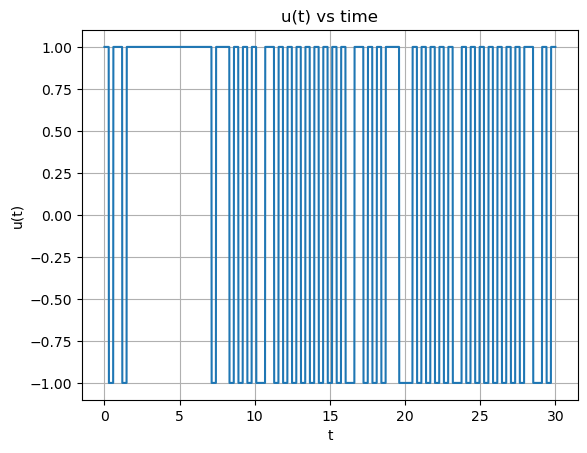

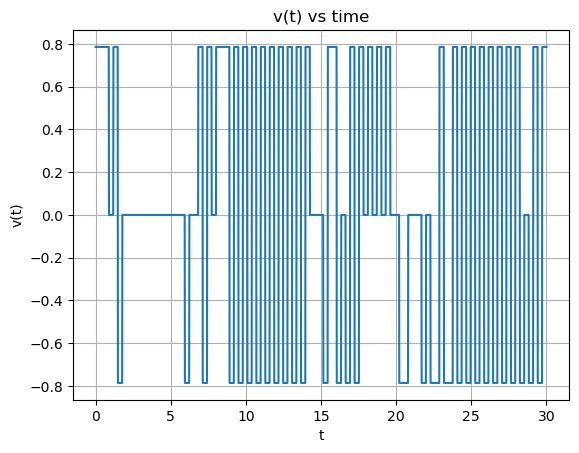

In [21]:
us=[2*(0.5-i%2) for i in u_t]
vs=[(1-i//2)*np.pi/4 for i in u_t]

u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])
        
x = np.linspace(0, T, (N+1)*20)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

## Last Trajectory


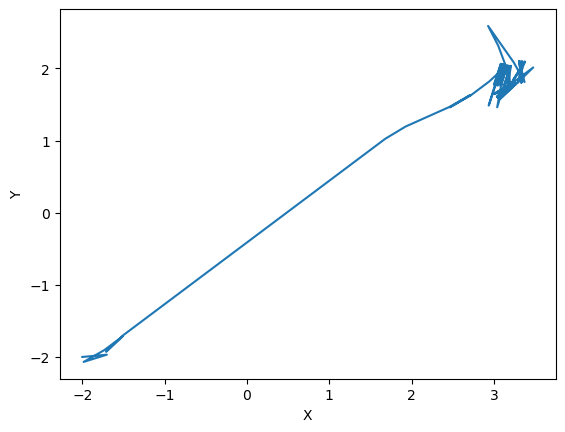

In [22]:
obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

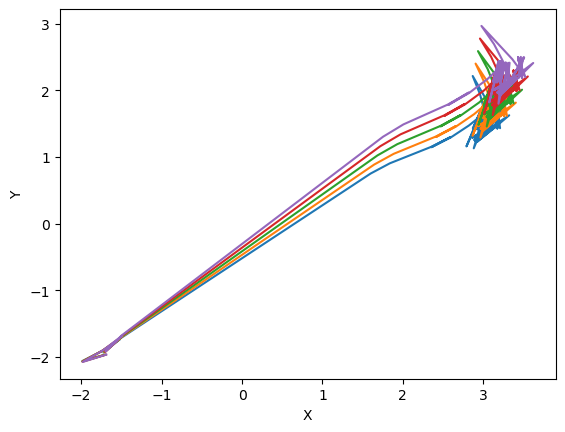

2.0970478670936554


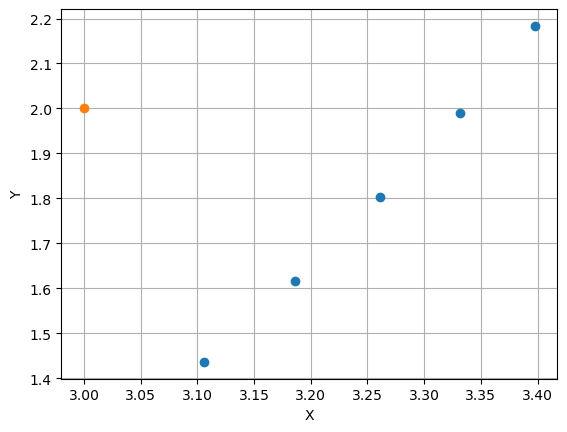

In [23]:
pos=[]
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(np.array(pos)))

cord_x=[]
cord_y=[]
for i in range(num_system):
    cord_x.append(pos[i][0])
    cord_y.append(pos[i][1])
plt.plot(np.array(cord_x),np.array(cord_y), 'o')
plt.plot(np.array([3]),np.array([2]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()


## Best Trajectory

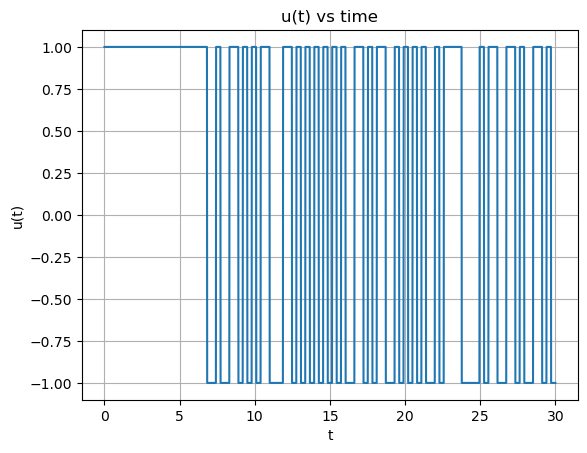

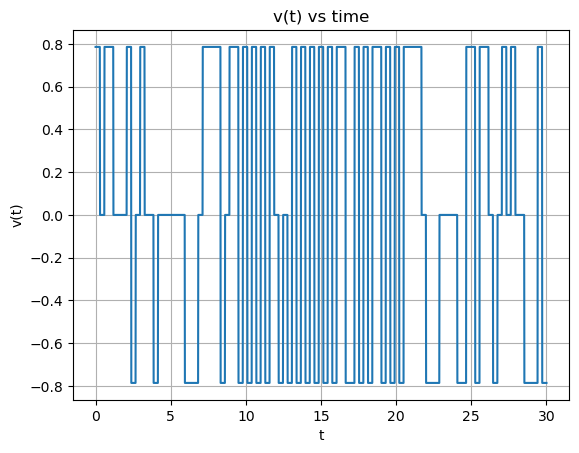

In [24]:
us=[2*(0.5-i%2) for i in best_u]
vs=[(1-i//2)*np.pi/4 for i in best_u]

u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

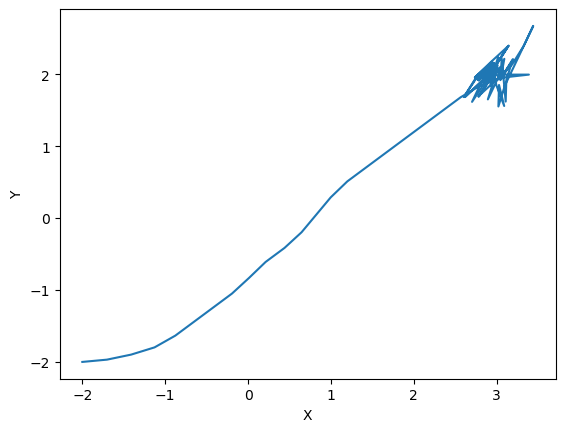

In [25]:
obs=np.array(best_obs)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

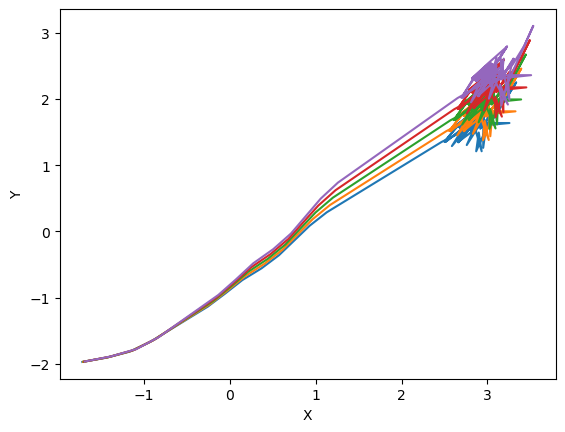

1.3136526996339608


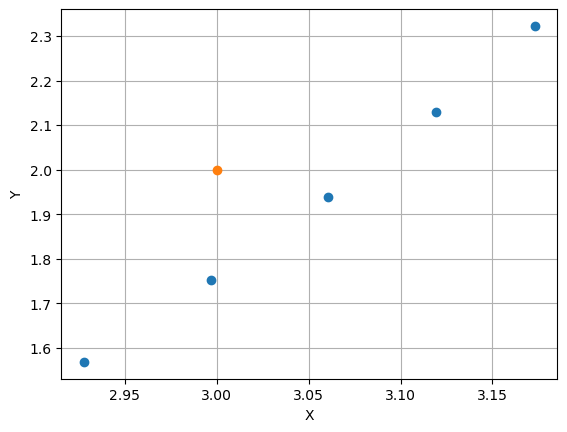

In [26]:
pos=[]
for i in range(num_system):
    obs=np.array(best_pos[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(np.array(pos)))

pos=[]
for i in range(num_system):
    obs=np.array(best_pos[i])
    obs=obs[:,[0,1]]
    #plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])

cord_x=[]
cord_y=[]
for i in range(num_system):
    cord_x.append(pos[i][0])
    cord_y.append(pos[i][1])
plt.plot(np.array(cord_x),np.array(cord_y), 'o')
plt.plot(np.array([3]),np.array([2]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()

## Pure Exploitation Trajectory

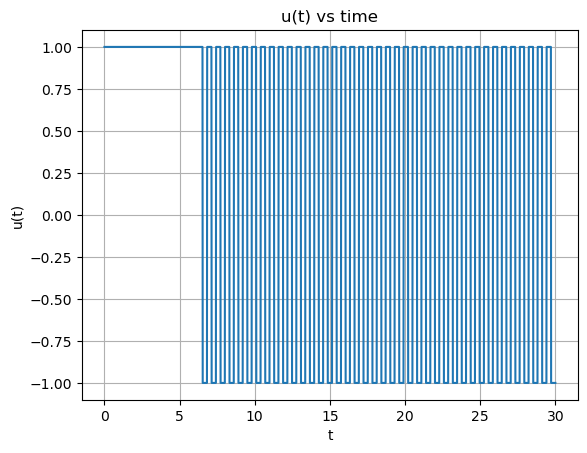

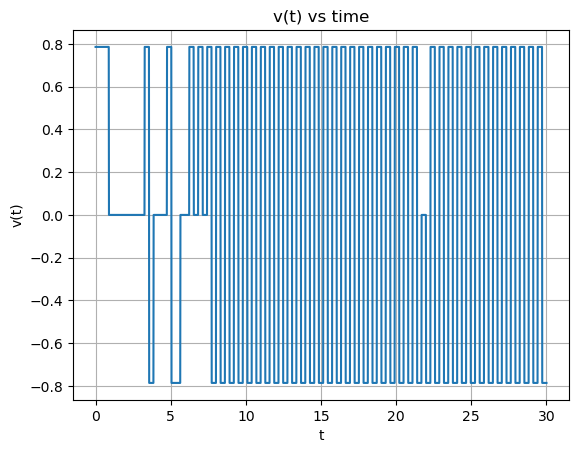

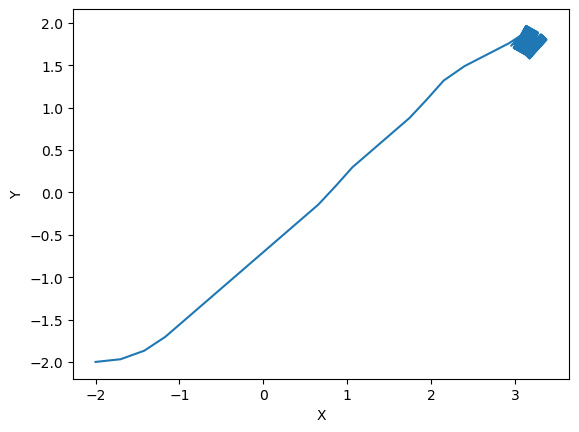

In [27]:
position=np.array([[-2,-2,0] for _ in range(num_system)])
observation=observe(position)
u_t=[]
observation_t=[observation]
position_t=[[] for i in range(num_system)]

for time in range(N+1):           
    
    #print(candidates_u)
    u_k = decide_u_exploitation(gpr_list[time],flags,observation)
    position_new = next_step(position,action_set[u_k])
    observation_new = observe(position_new)
    r = reward(observation_new)
    '''
    if explo:
        history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
        history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
    '''
    observation=observation_new
    position=position_new
    u_t.append(u_k)
    observation_t.append(observation)
    for i in range(num_system):
        position_t[i].append(position[i])
    '''
    if time%((N+1)//3+1)==0:
        for i in range(6):
            gpr_list[i]=GaussianProcessRegressor(alpha=1e-8).fit(history_su[i], history_r[i].reshape(-1,1))
    '''
    
us=[2*(0.5-i%2) for i in u_t]
vs=[(1-i//2)*np.pi/4 for i in u_t]

u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])
    

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

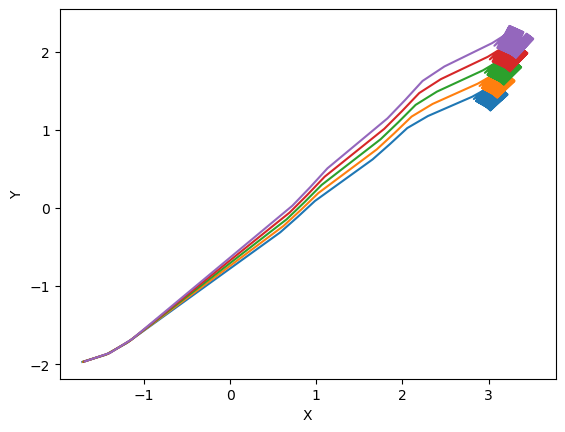

2.488826233243285


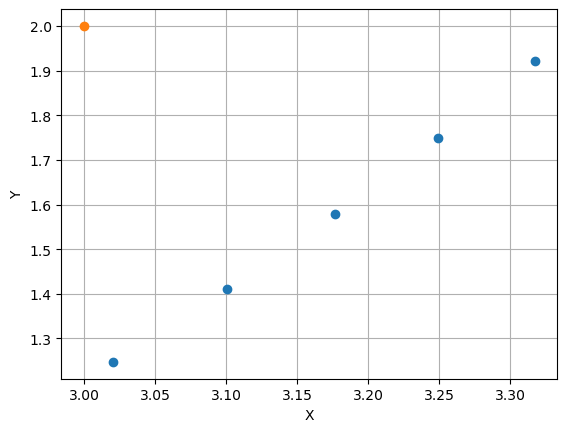

In [28]:
pos=[]
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(position))

cord_x=[]
cord_y=[]
for i in range(num_system):
    cord_x.append(pos[i][0])
    cord_y.append(pos[i][1])
plt.plot(np.array(cord_x),np.array(cord_y), 'o')
plt.plot(np.array([3]),np.array([2]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()